In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import logging


from diffusers import SD3Transformer2DModel, AutoencoderKL, FlowMatchEulerDiscreteScheduler
from transformers import CLIPTextModelWithProjection, CLIPTokenizer, T5EncoderModel, T5TokenizerFast

from diffusers.training_utils import compute_density_for_timestep_sampling, compute_loss_weighting_for_sd3, free_memory


from text_embed import encode_prompt, get_precomputed_tensors
from datasets import FillDataset
from sd3 import SD3CNModel, get_sigmas
from controlnext import ControlNeXtModel

2024-11-18 22:32:04.128626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 22:32:04.128680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 22:32:04.129824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 22:32:04.136903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 22:32:04.842873: W tensorflow/compiler/tf2

In [3]:
device = 'cuda:0'

In [4]:
with open('secrets.txt', 'r') as fh:
    key = fh.read()

In [5]:
from huggingface_hub import login
login(key)

In [6]:
# transformer = SD3CNModel.from_pretrained(
#     "stabilityai/stable-diffusion-3-medium-diffusers",
#     subfolder="transformer",
#     torch_dtype=torch.float16).to(device)
transformer = SD3CNModel.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    subfolder="transformer",
    ).to(device)

In [7]:
len(transformer.transformer_blocks)

24

In [44]:
from diffusers import SD3Transformer2DModel
transformer = SD3Transformer2DModel.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    subfolder="transformer",
    ).to(device)

In [6]:
vae = AutoencoderKL.from_pretrained(
            "stabilityai/stable-diffusion-3-medium",
            subfolder="vae",
            revision="refs/pr/26").to(device)

In [7]:
noise_scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", subfolder="scheduler"
)
noise_scheduler_copy = copy.deepcopy(noise_scheduler)

In [9]:
tensor_list = get_precomputed_tensors(device=device)
        
pixel_list = [x['img'] for x in tensor_list]
hint_list = [x['hint'] for x in tensor_list]
prompt_embed_list = [x['prompt_embeds'] for x in tensor_list]
pooled_prompt_embed_list = [x['pooled_prompt_embeds'] for x in tensor_list]

index = 1
prompt_embeds = prompt_embed_list[1].to(device)
pooled_prompt_embeds = pooled_prompt_embed_list[1].to(device)
print(tensor_list[index]['prompt'])



light coral circle with white background


In [10]:
pixel_list[0].shape

torch.Size([1, 3, 512, 512])

In [11]:
model_input = vae.encode(pixel_list[0]).latent_dist.sample()
model_input = (model_input - vae.config.shift_factor) * vae.config.scaling_factor
model_input.shape

torch.Size([1, 16, 64, 64])

In [12]:
control_input = vae.encode(hint_list[0]).latent_dist.sample()
control_input = (control_input - vae.config.shift_factor) * vae.config.scaling_factor
control_input.shape

torch.Size([1, 16, 64, 64])

In [13]:
tt = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(2, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(2, 64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(2, 128),
            # nn.ReLU(),
        ).to(device)

In [15]:
out = tt(control_input)
out.shape

torch.Size([1, 128, 64, 64])

In [16]:
# Sample noise that we'll add to the latents
noise = torch.randn_like(model_input)
bsz = model_input.shape[0]
# Sample a random timestep for each image
# for weighting schemes where we sample timesteps non-uniformly
u = compute_density_for_timestep_sampling(
    weighting_scheme="logit_normal",
    batch_size=1,
    logit_mean=0,
    logit_std=1,
    mode_scale=1.29,
)

indices = (u * noise_scheduler_copy.config.num_train_timesteps).long()
timesteps = noise_scheduler_copy.timesteps[indices].to(device=model_input.device)

# Add noise according to flow matching.
# zt = (1 - texp) * x + texp * z1
sigmas = get_sigmas(timesteps, noise_scheduler_copy, n_dim=model_input.ndim, dtype=model_input.dtype, device=device)
noisy_model_input = (1.0 - sigmas) * model_input + sigmas * noise

In [17]:
control_next = ControlNeXtModel(upscale_dim=1536).to(device)

In [18]:
control_next.embedding

Sequential(
  (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): GroupNorm(2, 64, eps=1e-05, affine=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): GroupNorm(2, 64, eps=1e-05, affine=True)
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): GroupNorm(2, 128, eps=1e-05, affine=True)
  (8): ReLU()
)

In [19]:
res = control_next(control_input, timesteps)
control_out = res['output']

HI
HI2
HI3
> /home/sj/workspace/diffusion/controlnext.py(137)forward()
    135             print("HI3")
    136             import pdb; pdb.set_trace()
--> 137             sample = res(sample, emb)
    138             sample = downsample(sample, emb)
    139 



ipdb>  c


/home/sj/diffusers/src/diffusers/models/downsampling.py:135: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)


HI3
> /home/sj/workspace/diffusion/controlnext.py(137)forward()
    135             print("HI3")
    136             import pdb; pdb.set_trace()
--> 137             sample = res(sample, emb)
    138             sample = downsample(sample, emb)
    139 



ipdb>  c


HI4
HI5


In [20]:
control_out.shape

torch.Size([1, 4096, 1536])

torch.Size([1, 3, 512, 512])


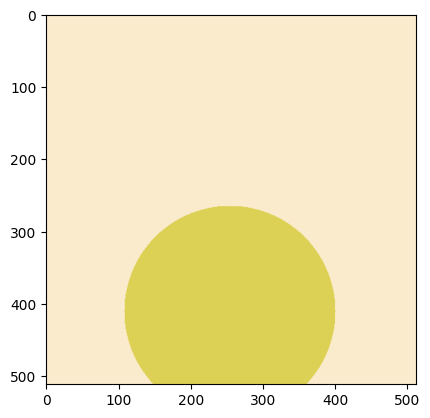

In [14]:
img = tensor_list[0]['img']
print(img.shape)
plt.imshow(img[0].permute(1,2,0).cpu())

In [18]:
from train_utils import generate_image
img = generate_image(transformer, vae, None, prompt_embeds, pooled_prompt_embeds, device, num_inference_steps=1000, num_images=10)

Step 101/1000, timestep: 900.0
Step 201/1000, timestep: 800.0
Step 301/1000, timestep: 700.0
Step 401/1000, timestep: 600.0
Step 501/1000, timestep: 500.0
Step 601/1000, timestep: 400.0
Step 701/1000, timestep: 300.0
Step 801/1000, timestep: 200.0
Step 901/1000, timestep: 100.0


In [20]:
img.shape

torch.Size([3, 576, 64])

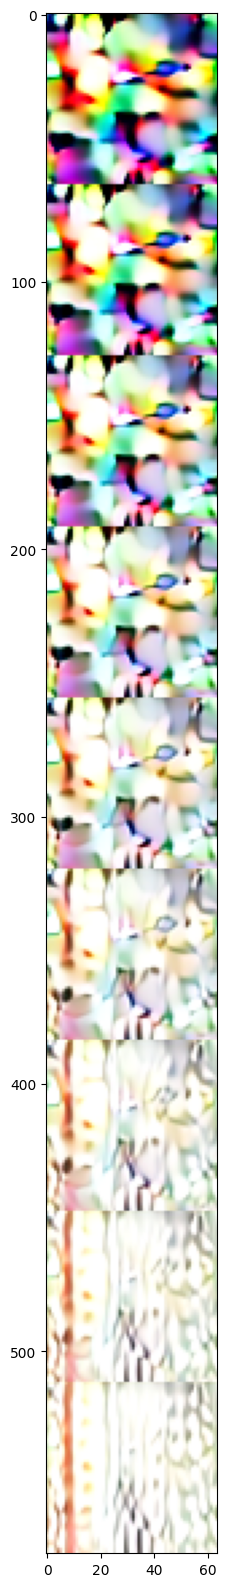

In [23]:
plt.figure(figsize = (10,20))
plt.imshow(img.permute(1,2,0))

In [14]:
# control_input = vae.encode(hint_list[0]).latent_dist.sample()
# control_input = (control_input - vae.config.shift_factor) * vae.config.scaling_factor

In [23]:
print(noisy_model_input.dtype, noisy_model_input.device)
print(timesteps.dtype, timesteps.device)
print(prompt_embeds.dtype, prompt_embeds.device)
print(pooled_prompt_embeds.dtype, pooled_prompt_embeds.device)


torch.float32 cuda:0
torch.float32 cuda:0
torch.float32 cuda:0
torch.float32 cuda:0


In [24]:
# Predict the noise residual
model_pred = transformer(
    hidden_states=noisy_model_input,
    timestep=timesteps,
    encoder_hidden_states=prompt_embeds,
    pooled_projections=pooled_prompt_embeds,
    controlnet_hidden_states=control_out,
    return_dict=False,
)[0]

In [25]:
model_pred.shape

torch.Size([1, 16, 64, 64])

In [26]:
decoded = vae.decode(model_pred).sample.cpu().detach().squeeze().permute(1,2,0)
min_val = decoded.min()
max_val = decoded.max()
decoded = (decoded - min_val) / (max_val - min_val)

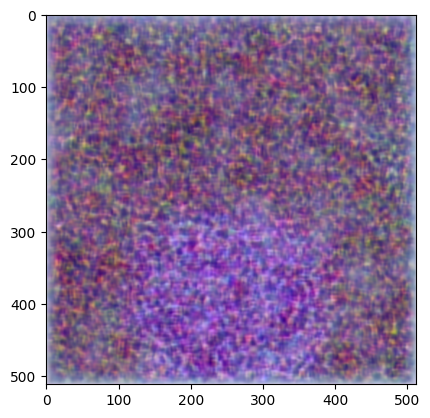

In [27]:
plt.imshow(decoded)

In [28]:
from trainer import retrieve_timesteps, get_scheduler



In [29]:
learning_rate = 1e-4
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_weight_decay = 1e-4
adam_epsilon = 1e-8


params_to_optimize = list(transformer.parameters()) + list(control_next.parameters())

optimizer = torch.optim.AdamW(
    params_to_optimize,
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

In [30]:
scheduler_type = "constant"
lr_warmup_steps = 500
max_train_steps = 1000
lr_num_cycles = 1
lr_power = 1.0

lr_scheduler = get_scheduler(
    scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=max_train_steps,
    num_cycles=lr_num_cycles,
    power=lr_power,
) 

In [31]:
batch_size = 1
height = 64
width = 64
num_channels_latents = transformer.config.in_channels
latents = torch.randn((batch_size, num_channels_latents, height, width), device=device)


In [36]:
from PIL import Image
import numpy as np

In [50]:
img2 = np.asarray(img)

In [45]:
import os
from torch.utils.tensorboard import SummaryWriter

In [46]:
base_log_dir="logs/sd3_training"
run_number=0
while os.path.exists(os.path.join(base_log_dir, f"run_{run_number}")):
    run_number += 1

log_dir = os.path.join(base_log_dir, f"run_{run_number}")
writer = SummaryWriter(log_dir=log_dir)

In [64]:
writer.close()

In [88]:
print()

In [121]:
control_out.shape

torch.Size([1, 1024, 1536])

In [122]:
temb = transformer.time_text_embed(timesteps[0].unsqueeze(0).to(device), pooled_prompt_embeds)

In [123]:
time_embed = temb.unsqueeze(1).expand(-1, control_out.size(1), -1)  # Shape [1, 1024, 1536]


In [126]:
transformer.config.num_layers

24

In [125]:
time_embed.shape

torch.Size([1, 1024, 1536])

In [90]:
num_channels_latents = transformer.config.in_channels
scheduler = FlowMatchEulerDiscreteScheduler()  # Ensure this scheduler is defined or imported properly

# Generate random latent noise
latents = torch.randn((batch_size, num_channels_latents, height, width), device=device)

# Retrieve timesteps for denoising
timesteps, num_inference_steps = retrieve_timesteps(scheduler, num_inference_steps=1000)

In [92]:
timesteps

tensor([1000.0000,  999.0000,  998.0000,  997.0000,  996.0000,  995.0000,
         994.0000,  993.0000,  992.0000,  991.0000,  990.0000,  989.0000,
         988.0000,  987.0000,  986.0000,  985.0000,  984.0000,  983.0000,
         982.0000,  981.0000,  980.0000,  979.0000,  978.0000,  977.0000,
         976.0000,  975.0000,  974.0000,  973.0000,  972.0000,  971.0000,
         970.0000,  969.0000,  968.0000,  967.0000,  966.0000,  965.0000,
         964.0000,  963.0000,  962.0000,  961.0000,  960.0000,  959.0000,
         958.0000,  957.0000,  956.0000,  955.0000,  954.0000,  953.0000,
         952.0000,  951.0000,  950.0000,  949.0000,  948.0000,  947.0000,
         946.0000,  945.0000,  944.0000,  943.0000,  942.0000,  941.0000,
         940.0000,  939.0000,  938.0000,  937.0000,  936.0000,  935.0000,
         934.0000,  933.0000,  932.0000,  931.0000,  930.0000,  929.0000,
         928.0000,  927.0000,  926.0000,  925.0000,  924.0000,  923.0000,
         922.0000,  921.0000,  920.000

In [119]:
control_projection= transformer.control_projection

In [100]:
temb = transformer.time_text_embed(timesteps[0].unsqueeze(0).to(device), pooled_prompt_embeds)

In [109]:
temb.shape

torch.Size([1, 1536])

In [115]:
tmp = torch.concat([temb, temb], dim=1)

In [120]:
control_projection(tmp)

tensor([[-0.1610,  0.2207, -1.3412,  ...,  3.1358,  0.6256, -0.2649]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [102]:
temb.shape

torch.Size([1, 1536])

In [52]:
prompt_embeds

tensor([[[-3.8936e+00, -2.5127e+00,  4.7188e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 7.7929e-01, -8.5759e-01,  4.5031e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 6.9617e-01,  6.5248e-01, -6.1702e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 5.8604e-02, -9.4705e-03,  4.5249e-02,  ...,  3.5161e-04,
          -4.8218e-02, -1.8796e-02],
         [ 4.1846e-02,  6.9982e-03, -7.5475e-02,  ..., -1.1780e-01,
          -7.6643e-02, -4.8851e-02],
         [-2.6073e-03,  2.3205e-02, -8.6759e-03,  ...,  2.3499e-03,
          -2.0340e-02,  1.3123e-02]]], device='cuda:0')

In [74]:
img = generate_image(transformer, vae, control_next, prompt_embeds, pooled_prompt_embeds, device, num_inference_steps=40)

plt.figure(figsize = (10,20))
img2 = torch.tensor(np.asarray(img))
plt.imshow(img2)

Step 8/40, timestep: 795.076904296875


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 1000x2000 with 0 Axes>

In [75]:
img.shape

torch.Size([1, 3, 512, 512])

In [ ]:
def prepare_latents(
    batch_size,
    num_channels_latents,
    height,
    width,
    dtype,
    device,
    generator,
    latents=None,
):
    if latents is not None:
        return latents.to(device=device, dtype=dtype)

    shape = (
        batch_size,
        num_channels_latents,
        int(height) // self.vae_scale_factor,
        int(width) // self.vae_scale_factor,
    )

    if isinstance(generator, list) and len(generator) != batch_size:
        raise ValueError(
            f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
            f" size of {batch_size}. Make sure the batch size matches the length of the generators."
        )

    latents = randn_tensor(shape, generator=generator, device=device, dtype=dtype)

    return latents

In [ ]:
latents = None
latents = self.prepare_latents(
    batch_size * num_images_per_prompt,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator,
    latents,
)

In [71]:
pooled_prompt_embeds

tensor([[ 0.1887,  0.6689, -0.6597,  ..., -0.4067,  1.9429,  0.5551]],
       device='cuda:0')

In [68]:
prompt_embeds

tensor([[[-3.8936e+00, -2.5127e+00,  4.7188e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-1.0328e-01, -3.1293e-01,  4.4931e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 5.5993e-01,  1.1991e-01, -5.6052e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 6.3218e-02, -1.0868e-02,  4.6917e-02,  ...,  1.9617e-04,
          -4.8270e-02, -2.1857e-02],
         [ 3.1729e-02,  4.7609e-03, -6.6126e-02,  ..., -1.0854e-01,
          -6.8419e-02, -5.9926e-02],
         [-2.3687e-03,  2.2861e-02, -8.0716e-03,  ...,  4.5892e-03,
          -2.1196e-02,  1.0936e-02]]], device='cuda:0')

In [65]:
height = 64
width = 64
num_channels_latents = transformer.config.in_channels
scheduler = FlowMatchEulerDiscreteScheduler()  # Ensure this scheduler is defined or imported properly

# Generate random latent noise
latents = torch.randn((1, num_channels_latents, height, width), device=device)
# latents = latents * scheduler.init_noise_sigma

In [73]:
from train_utils import retrieve_timesteps

import torch
import numpy as np
from PIL import Image
from typing import List, Optional, Union
import inspect
from diffusers import FlowMatchEulerDiscreteScheduler
import torch.nn.functional as F

def generate_image(transformer, vae, control_next, text_embeddings, pooled_projections, device, num_inference_steps=30, num_images=5, batch_size=1, height=64, width=64):
    # Configuration from transformer
    num_channels_latents = transformer.config.in_channels
    scheduler = FlowMatchEulerDiscreteScheduler()  # Ensure this scheduler is defined or imported properly
    
    # Generate random latent noise
    latents = torch.randn((batch_size, num_channels_latents, height, width), device=device)
    # latents = latents * scheduler.init_noise_sigma
    
    # Retrieve timesteps for denoising
    timesteps, num_inference_steps = retrieve_timesteps(scheduler, num_inference_steps=num_inference_steps)
    timesteps = timesteps.to(device)
    
    # List to hold intermediate images
    images_list = []
    
    # Iteratively denoise latents
    for index, t in enumerate(timesteps):
        if index % (num_inference_steps // num_images) == 0 and index != 0:
            print(f"Step {index}/{num_inference_steps}, timestep: {t}")
            
            # Decode latents to an image
            with torch.no_grad():
                # latents2 = latents
                # latents2 = 1 / 0.18215 * latents
                latents2 = (latents / vae.config.scaling_factor) + vae.config.shift_factor
                image = vae.decode(latents2).sample
                return image
            
            # Post-process image
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()
            
            # Convert the numpy array to a PIL image and add to list
            pil_image = Image.fromarray((image[0] * 255).astype(np.uint8))
            images_list.append(pil_image)
        
        # Predict the noise residual
        with torch.no_grad():
            noise_pred = transformer(
                latents, 
                timestep=t.view(-1), 
                encoder_hidden_states=text_embeddings, 
                pooled_projections=pooled_projections
            ).sample
        
        # Compute the previous noisy sample
        latents = scheduler.step(noise_pred, t.view(-1), latents).prev_sample
    
    # Concatenate images in a grid (vertically)
    num_images = len(images_list)
    grid_width = width
    grid_height = height * num_images
    grid_image = Image.new("RGB", (grid_width, grid_height))
    
    for i, img in enumerate(images_list):
        grid_image.paste(img, (0, i * height))
    
    # Display the final grid image
    return grid_image